Manel Azoun\
84966753\
DSCI 100 008\
05/11/24

# Individual Project Plan

In [1]:
#Load necessary libraries
library(tidyverse) 
library(dplyr) 
library(ggplot2) 
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## (1) Data Description

`players_data` contains demographic information of each player, collected when the players register for the Minecraft server.
- Observations: 196 
- Variables: 9

In [2]:
#Coded table describing the variables (not included in the word limit)

players_variable_summary <- tibble(Variable_name = c("experience", "suscribe", "hashedEmail",
                                        "played_hours",	"name",	"gender", "age", "individualId", "organizationName"), 
                           Variable_description = c("Player’s Minecraft experience", "Whether the player is subscribed for server emails", 
                                                    "Encrypted players’ email for anonymity", "Hours the player has spent on the server", 
                                                    "Player’s in-name game", "Player’s gender", "Player’s age", "Identifier of the player",
                                                    "Organization of the player"),
                           Variable_type = c("Categorical (character)", "Logical", "Categorical (character)", "Numerical", "Categorical (character)", 
                                             "Categorical (character)", "Numerical", "Logical", "Logical")) 
players_variable_summary

Variable_name,Variable_description,Variable_type
<chr>,<chr>,<chr>
experience,Player’s Minecraft experience,Categorical (character)
suscribe,Whether the player is subscribed for server emails,Logical
hashedEmail,Encrypted players’ email for anonymity,Categorical (character)
played_hours,Hours the player has spent on the server,Numerical
name,Player’s in-name game,Categorical (character)
gender,Player’s gender,Categorical (character)
age,Player’s age,Numerical
individualId,Identifier of the player,Logical
organizationName,Organization of the player,Logical


Issues:
- `inidivdualId` and `organizationName` columns contain NULL values.
- `age` and `gender` may be misreported (e.g., age 99), affecting engagement patterns.
- No distinct definitions on `experience` levels, resulting in varied interpretations.
  
Potential issues:
- Large imbalances within the variables could skew the demographics.
- Email hashing prevents data verification.

-------------------------------------------------------------------------------------------------------------------------------------------------

`sessions_data` records the history of each individual player’s sessions in the server, collected through server logs.
- Observations: 1535 
- Variables: 5

In [3]:
#Coded table describing the variables (not included in the word limit)

sessions_variable_summary <- tibble(Variable_name = c("hashedEmail", "start_time", "end_time", "original_start_time", "original_end_time"), 
                           Variable_description = c("Encrypted players’ email for anonymity", "Date and time when the player’s session has begun",
                                                    "Date and time when the player’s session has ended",
                                                    "Scheduled start time of the player’s session in Unix timestamp format", 
                                                    "Scheduled end time of the player’s session in Unix timestamp format"),
                           Variable_type = c("Categorical (character)", "Categorical (character)", "Cateogrical (character)", 
                                             "Numerical", "Numerical"))
sessions_variable_summary

Variable_name,Variable_description,Variable_type
<chr>,<chr>,<chr>
hashedEmail,Encrypted players’ email for anonymity,Categorical (character)
start_time,Date and time when the player’s session has begun,Categorical (character)
end_time,Date and time when the player’s session has ended,Cateogrical (character)
original_start_time,Scheduled start time of the player’s session in Unix timestamp format,Numerical
original_end_time,Scheduled end time of the player’s session in Unix timestamp format,Numerical


Issues:
- `start_time` and `end_time` log the date and time together, complicating duration calculations.

Potential issues:
- `original_start_time` and `original_end_time` may be irrelevant.
- Inactive players could result in overestimated session lengths.
- Fragmented session records could affect accurate engagement patterns.

## (2) Question

How can we forecast the *number of simultaneous players* based on the *hour of the day* and *day of the week*? 

The response variable is `total_players`, and the explanatory variables are `start_hour` and `start_day`, which will be created after data wrangling. The data will help us identify peak usage periods to ensure the server has enough licenses for high-demand time windows. To wrangle the data, we will exclude `individualId` and `organizationName` due to NULL values, transform `original_start_time` and `original_end_time` into a date-time format, and separate `start_time` and `end_time` into distinct date and time variables. After merging the wrangled data sets, we can create our target variable and predictors.

## (3) Exploratory Data Analysis and Visualization

In [4]:
#Wrangling data for data analysis
#Load the data sets 
players_url <- "https://raw.githubusercontent.com/manel-azn/Manel_Individual_Project_Data/refs/heads/main/players.csv"
players_data <- read_csv(players_url)

sessions_url <- "https://raw.githubusercontent.com/manel-azn/Manel_Individual_Project_Data/refs/heads/main/sessions.csv"
sessions_data <- read_csv(sessions_url)

#Select only relevant columns in players_data
players_data <- players_data |>
                select(-individualId, -organizationName)

#Convert original_start_time and original_end_time from UNIX timestamps
sessions_data <- sessions_data |>
                    mutate(original_start_time = as_datetime(original_start_time), 
                           original_end_time = as_datetime(original_end_time))

#Separate the date and time from start_time and end_time into two separate columns
sessions_data <- sessions_data |>
                    separate(start_time, into = c("start_date", "start_time"), sep = " ") |>
                    separate(end_time, into = c("end_date", "end_time"), sep = " ")

#Merge players_data and sessions_data to have on data frame to work wtih
merged_data <- inner_join(players_data, sessions_data, by = "hashedEmail")

#Note: Each row represents a unique gameplay session
#Display only a few rows of the merged data frame
head(merged_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dttm>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,08/08/2024,00:21,08/08/2024,01:35,56572-03-25 13:20:00,56572-03-25 13:20:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,09/09/2024,22:30,09/09/2024,22:37,56662-03-24 22:13:20,56662-03-24 22:13:20
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,08/08/2024,02:41,08/08/2024,03:25,56572-03-25 13:20:00,56572-07-19 07:06:40
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,10/09/2024,15:07,10/09/2024,15:29,56664-02-17 08:53:20,56664-02-17 08:53:20
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,05/05/2024,22:21,05/05/2024,23:17,56314-08-09 08:00:00,56314-08-09 08:00:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,06/04/2024,22:24,06/04/2024,23:33,56235-01-24 09:46:40,56235-05-20 03:33:20


start_hour,total_players
<int>,<int>
0,128
1,79
2,152
3,131
4,151
5,88


`summarise()` has grouped output by 'start_day'. You can override using the
`.groups` argument.


start_day,start_hour,total_players
<ord>,<int>,<int>
Sun,0,13
Sun,1,10
Sun,2,12
Sun,3,13
Sun,4,21
Sun,5,15


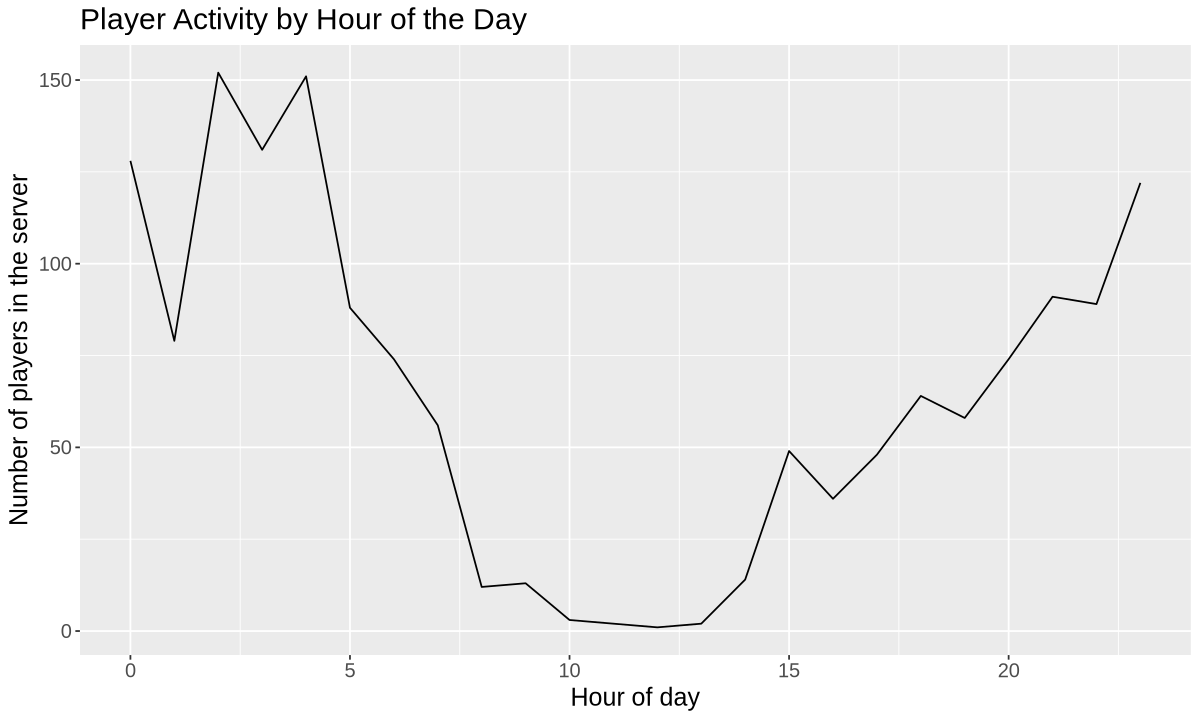

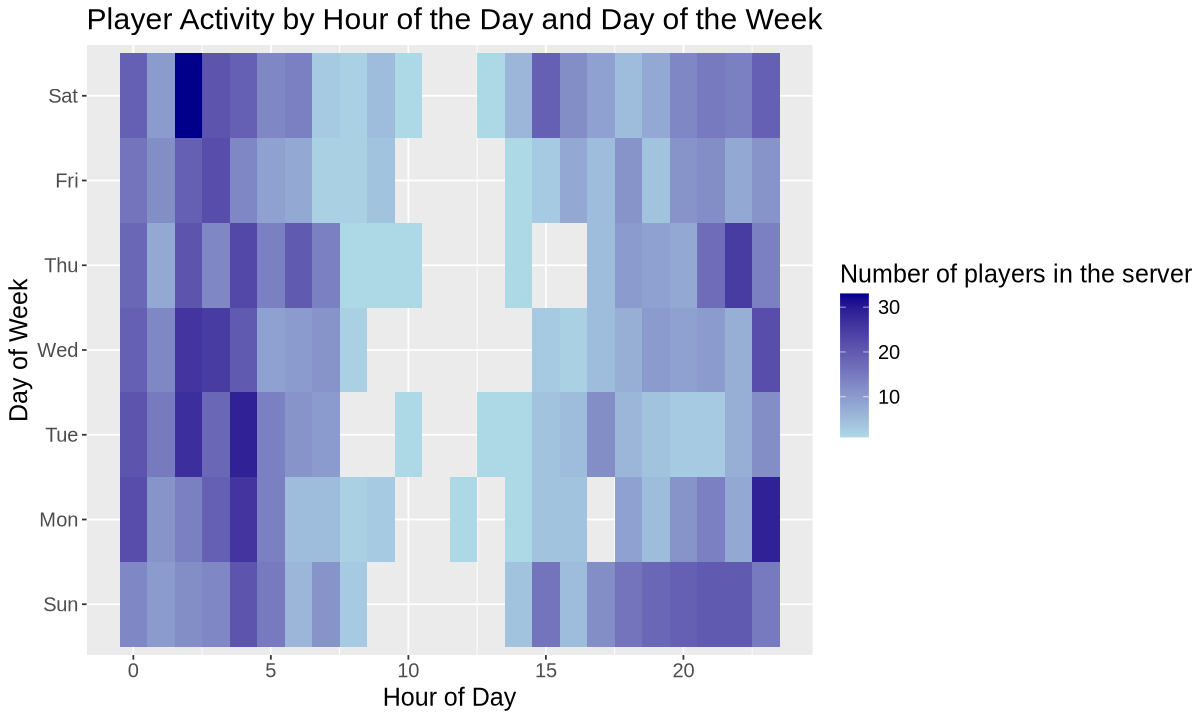

In [6]:
#Data visualizations

#Plot dimensions
options(repr.plot.height = 6, repr.plot.width = 10)

#Turn start time and start data into as.POSIXct format
merged_data$start_time <- as.POSIXct(merged_data$start_time, format = "%H:%M")
merged_data$start_date <- as.POSIXct(merged_data$start_date, format = "%d/%m/%Y")

# Extract hour from start time
merged_data$start_hour <- hour(merged_data$start_time)

# Extract day of the week from start date
merged_data$start_day <- wday(merged_data$start_date, label = TRUE)

# Count players active during each hour
hourly_player_counts <- merged_data |>
                            group_by(start_hour) |>
                            summarise(total_players = n())
head(hourly_player_counts)

# Line plot to visualize players' hourly engagement
hourly_player_plot <- ggplot(hourly_player_counts, aes(x = start_hour, y = total_players)) +
                        geom_line() +
                        xlab("Hour of day") +
                        ylab("Number of players in the server") +
                        ggtitle("Player Activity by Hour of the Day") +
                        theme(text = element_text(size =15))
hourly_player_plot

# Count players by day and hour
day_hour_player_counts <- merged_data |>
                            group_by(start_day, start_hour) |>
                            summarise(total_players = n())
head(day_hour_player_counts)

# Heatmap to visualize players' engagement by day and hour
day_hour_player_plot <- ggplot(day_hour_player_counts, aes(x = start_hour, y = start_day, fill = total_players)) +
                            geom_tile() +
                            scale_fill_gradient(low = "lightblue", high = "darkblue") +
                            labs(x = "Hour of Day", 
                                 y = "Day of Week", 
                                 title = "Player Activity by Hour of the Day and Day of the Week", 
                                 fill = "Number of players in the server") +
                            theme(text = element_text(size =15))
day_hour_player_plot

The line plot shows that the server activity peaks between 1a.m. and 4:30a.m., with engagement highest around 2a.m.. Activity is lower between 8a.m. and 3p.m., but it picks up again towards midnight, indicating that evenings are also important for server demand. The heat map supports this, but also shows that the days of the week have minimal impact, with only slight dips in activity on Fridays and Sundays. Thus, for forecasting, the time of day (rather than the specific day) is the most important variable for predicting simultaneous players, helping server resources to be allocated effectively during peak times.

## (4) Methods and Plan

I propose using K-Nearest Neighbours (KNN) regression to forecast the number of simultaneous players, as it is effective for capturing non-linear relationships between it and the explanatory variables, hour of day and day of week. KNN assumes that similar data points will have similar outcomes, making it suitable for modelling simultaneous activity that follows temporal patterns. Potential limitations of KNN include the model's sensitivity to outliers and becoming slow as the training data expands. I will first preprocess the data by encoding categorical variables (e.g., converting days of the week into integers like Sunday = 1) and standardizing the numerical predictors. I will then split the data into a 70% training set and 30% testing set. 5-fold cross-validation will then be used on the training set to tune the model and select the best k value. Model evaluation by RMSE on the training set and RMSPE on the testing set will assess accuracy and generalization.